In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gdp
from collections import Counter
from sklearn import preprocessing

### First, some pre-process of the data

Things to do:
- Check if 'ON STREET NAME' contains some prudent data like st, bridge, tunnel, express way etc. generate features.
- Check for most mentioned st. names
- Check for holidays and mark those day
- Divide the city into a grid
- Count # of CONTRIBUTING FACTORs and # of VEHICLE TYPE CODE. generate features

In [2]:
df = pd.read_csv(r'../../Machine Learning/Data Incubator/Motor_Vehicle_Collisions_-_Crashes.csv')

C:\Users\Lenovo\Anaconda3\envs\cs231n\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
# Checking for missing values first

In [4]:
# df.isna().sum()

In [5]:
# Look only at pre-covid records for now
df = df[df['CRASH DATE'] < '2019-12-31'].reset_index(drop=True)

In [6]:
# Drop rows with NaN for # of injuries or death for simplicity (can be dealt with later)
df = df.dropna(subset=['NUMBER OF PERSONS INJURED','NUMBER OF PERSONS KILLED']).reset_index(drop=True)

In [7]:
# Sanity check if numbers sum up (should sum up!)
(df['NUMBER OF PERSONS KILLED'] != df['NUMBER OF PEDESTRIANS KILLED'] + \
 df['NUMBER OF CYCLIST KILLED'] + df['NUMBER OF MOTORIST KILLED']).sum()

14

In [8]:
# Sanity check if numbers sum up (should sum up!)
(df['NUMBER OF PERSONS INJURED'] != df['NUMBER OF PEDESTRIANS INJURED'] + \
 df['NUMBER OF CYCLIST INJURED'] + df['NUMBER OF MOTORIST INJURED']).sum()

682

In [9]:
# Dropping all of those outliers cases for now, deal with it later

In [10]:
df = df[(df['NUMBER OF PERSONS KILLED'] == df['NUMBER OF PEDESTRIANS KILLED'] + \
 df['NUMBER OF CYCLIST KILLED'] + df['NUMBER OF MOTORIST KILLED'])].reset_index(drop=True)

In [11]:
df = df[(df['NUMBER OF PERSONS INJURED'] == df['NUMBER OF PEDESTRIANS INJURED'] + \
 df['NUMBER OF CYCLIST INJURED'] + df['NUMBER OF MOTORIST INJURED'])].reset_index(drop=True)

In [12]:
df[['NUMBER OF PERSONS INJURED','NUMBER OF PERSONS KILLED']] = df[['NUMBER OF PERSONS INJURED','NUMBER OF PERSONS KILLED']].astype('int64')

In [13]:
# Replacing NaN values with empty string 

In [14]:
df['ON STREET NAME'] = df['ON STREET NAME'].fillna('')
df['CROSS STREET NAME'] = df['CROSS STREET NAME'].fillna('')
df['OFF STREET NAME'] = df['OFF STREET NAME'].fillna('')

In [15]:
df = df.drop(columns=['ON STREET NAME','CROSS STREET NAME','OFF STREET NAME'])

In [16]:
# Looking for most common names, bulding features later for the relevant ones
# Will use this later
# Counter(" ".join(df['OFF STREET NAME']).split()).most_common(100)

### Time and Date Feature

In [17]:
df['CRASH TIME'] = pd.to_datetime(df['CRASH TIME']).dt.hour
y = pd.get_dummies(df['CRASH TIME'], prefix='CRASH_HR')
df = pd.concat([df, y], axis=1)
df = df.drop(columns=['CRASH TIME'])
df['CRASH DATE'] = pd.to_datetime(df['CRASH DATE'])
df['day'] = df['CRASH DATE'].dt.day_name()
y = pd.get_dummies(df['day'], prefix='CRASH_DAY')
df = pd.concat([df, y], axis=1)
df = df.drop(columns=['day'])
df['month'] = df['CRASH DATE'].dt.month_name()
y = pd.get_dummies(df['month'], prefix='CRASH_MONTH')
df = pd.concat([df, y], axis=1)
df = df.drop(columns=['month'])
df = df.drop(columns=['CRASH DATE'])

### Location Features

In [18]:
# Dropping all missing locations for now, deal with it later
df = df.dropna(subset=['LATITUDE','LONGITUDE']).reset_index(drop=True)

In [19]:
df['LONGITUDE'][df['LONGITUDE']==0].count()

1176

In [20]:
df['LATITUDE'][(df['LATITUDE']<=40.92)&(df['LATITUDE']>=40.49)].sort_values()

1181556    40.498949
1426660    40.498949
856370     40.499135
512382     40.499310
1028369    40.499479
             ...    
369202     40.912884
650038     40.912884
337841     40.912884
128537     40.912884
612471     40.912884
Name: LATITUDE, Length: 1492054, dtype: float64

In [21]:
df['LONGITUDE'][(df['LONGITUDE']<=-73.5)&(df['LONGITUDE']>=-74.5)].sort_values()

1166775   -74.254532
398853    -74.253930
758632    -74.253174
869604    -74.253031
31306     -74.253006
             ...    
280582    -73.700584
708186    -73.700584
508338    -73.700550
361338    -73.700550
821330    -73.663010
Name: LONGITUDE, Length: 1491933, dtype: float64

In [22]:
# Dropping locations values that are not within NYC for now, deal with it later

In [23]:
df = df[(df['LATITUDE']<=40.92)&(df['LATITUDE']>=40.49)]

In [24]:
df = df[(df['LONGITUDE']<=-73.5)&(df['LONGITUDE']>=-74.5)]

In [25]:
df['LONGITUDE'].max()

-73.66301

In [26]:
df = df.reset_index(drop=True)

In [27]:
df['LATITUDE'].max()-df['LATITUDE'].min()

0.4139352000000116

In [28]:
df['LONGITUDE'].max()-df['LONGITUDE'].min()

0.5915215999999788

In [29]:
Number_of_Cells = 100
step = (df['LATITUDE'].max()-df['LATITUDE'].min())/Number_of_Cells
to_bin = lambda x: np.floor(x / step) * step
df["lat_bin"] = df['LATITUDE'].map(to_bin)
df["lon_bin"] = df['LONGITUDE'].map(to_bin)

In [30]:
df["lat_bin"].unique().size

101

In [31]:
df["lon_bin"].unique().size

135

In [32]:
nyc = gdp.read_file(gdp.datasets.get_path('nybb'))

In [33]:
nyc = nyc.to_crs("EPSG:4326")

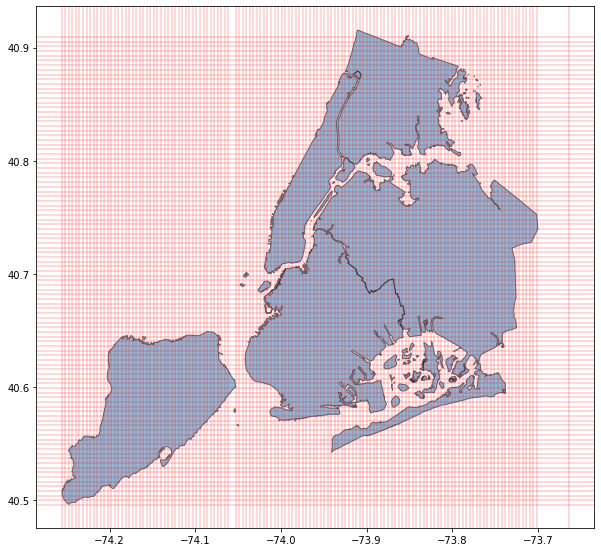

In [34]:
# Plot the generated grid
ax =nyc.plot(figsize=(10, 10), alpha=0.5, edgecolor='k')
for i in df["lat_bin"].unique():
    plt.axhline(i, color='r', alpha=0.2)
for i in df["lon_bin"].unique():
    plt.axvline(i, color='r' , alpha=0.2)  
# plt.xlim(-74, -73.89)
# plt.ylim(40.49, 40.68)
plt.show() 

In [35]:
y = pd.get_dummies(df['lat_bin'], prefix='lat_bin')

In [36]:
df = pd.concat([df, y], axis=1)

In [37]:
y = pd.get_dummies(df['lon_bin'], prefix='lon_bin')

In [38]:
df = pd.concat([df, y], axis=1)

In [39]:
df = df.drop(columns=['BOROUGH','ZIP CODE','LATITUDE','LONGITUDE','LOCATION','lat_bin','lon_bin'])

### Features for contributing factors

In [40]:
y1 = pd.get_dummies(df['CONTRIBUTING FACTOR VEHICLE 1'], prefix='FACTOR')

In [41]:
# Dropping double columns

y1['FACTOR_Cell Phone (hand-held)'] = y1['FACTOR_Cell Phone (hand-held)']+y1['FACTOR_Cell Phone (hand-Held)']
y1['FACTOR_Drugs (illegal)'] = y1['FACTOR_Drugs (illegal)'] + y1['FACTOR_Drugs (Illegal)']
y1 = y1.drop(columns=['FACTOR_Drugs (Illegal)', 'FACTOR_Cell Phone (hand-Held)'])

In [42]:
y1.columns = map(str.lower, y1.columns)

In [43]:
y2 = pd.get_dummies(df['CONTRIBUTING FACTOR VEHICLE 2'], prefix='FACTOR')

In [44]:
# Dropping double columns

y2['FACTOR_Cell Phone (hand-held)'] = y2['FACTOR_Cell Phone (hand-held)'] + y2['FACTOR_Cell Phone (hand-Held)']
y2['FACTOR_Drugs (illegal)'] = y2['FACTOR_Drugs (illegal)'] + y2['FACTOR_Drugs (Illegal)']
y2 = y2.drop(columns=['FACTOR_Drugs (Illegal)', 'FACTOR_Cell Phone (hand-Held)'])

In [45]:
y2.columns = map(str.lower, y2.columns)

In [46]:
y3 = pd.get_dummies(df['CONTRIBUTING FACTOR VEHICLE 3'], prefix='FACTOR')

In [47]:
y3['FACTOR_Drugs (illegal)'] = y3['FACTOR_Drugs (illegal)'] + y3['FACTOR_Drugs (Illegal)']
y3 = y3.drop(columns=['FACTOR_Drugs (Illegal)'])

In [48]:
y3.columns = map(str.lower, y3.columns)

In [49]:
y4 = pd.get_dummies(df['CONTRIBUTING FACTOR VEHICLE 4'], prefix='FACTOR')

In [50]:
y4['FACTOR_Drugs (illegal)'] = y4['FACTOR_Drugs (illegal)'] + y4['FACTOR_Drugs (Illegal)']
y4 = y4.drop(columns=['FACTOR_Drugs (Illegal)'])

In [51]:
y4.columns = map(str.lower, y4.columns)

In [52]:
y5 = pd.get_dummies(df['CONTRIBUTING FACTOR VEHICLE 5'], prefix='FACTOR')

In [53]:
y5.columns = map(str.lower, y5.columns)

In [54]:
y = y1.add(y2,fill_value=0).add(y3,fill_value=0).add(y4, fill_value=0).add(y5, fill_value=0)

In [55]:
y.columns.values.size

59

In [56]:
y = y.astype('uint8')

In [57]:
y['number_of_factors'] = y.sum(axis=1)

In [58]:
# # Normlize
# y = y/y.max()

In [59]:
df = pd.concat([df, y], axis=1)

In [60]:
df = df.drop(columns=['CONTRIBUTING FACTOR VEHICLE 1','CONTRIBUTING FACTOR VEHICLE 2','CONTRIBUTING FACTOR VEHICLE 3' \
                     , 'CONTRIBUTING FACTOR VEHICLE 4', 'CONTRIBUTING FACTOR VEHICLE 5'])

### Features for VEHICLE TYPE

In [61]:
df.loc[:,'VEHICLE TYPE CODE 1':'VEHICLE TYPE CODE 5'].columns

Index(['VEHICLE TYPE CODE 1', 'VEHICLE TYPE CODE 2', 'VEHICLE TYPE CODE 3',
       'VEHICLE TYPE CODE 4', 'VEHICLE TYPE CODE 5'],
      dtype='object')

In [62]:
df['number_of_vehicles'] = df['VEHICLE TYPE CODE 1'].notna().astype('uint8') + \
df['VEHICLE TYPE CODE 2'].notna().astype('uint8') + \
df['VEHICLE TYPE CODE 3'].notna().astype('uint8') + \
df['VEHICLE TYPE CODE 4'].notna().astype('uint8') + \
df['VEHICLE TYPE CODE 5'].notna().astype('uint8')

In [63]:
for column in df.loc[:,'VEHICLE TYPE CODE 1':'VEHICLE TYPE CODE 5'].columns:
    df[column] = df[column].fillna('')

In [64]:
for column in df.loc[:,'VEHICLE TYPE CODE 1':'VEHICLE TYPE CODE 5'].columns:
    df[column] = df[column].str.lower()

In [65]:
Counter(" ".join(df['VEHICLE TYPE CODE 1']).split()).most_common(30)

[('vehicle', 649955),
 ('utility', 444569),
 ('station', 444566),
 ('sedan', 401123),
 ('passenger', 347153),
 ('wagon/sport', 293650),
 ('/', 151731),
 ('wagon', 150955),
 ('sport', 150916),
 ('taxi', 67818),
 ('truck', 60440),
 ('pick-up', 33880),
 ('dr', 30188),
 ('van', 28817),
 ('4', 28338),
 ('bus', 26264),
 ('com', 22946),
 ('tires)', 22884),
 ('other', 19561),
 ('unknown', 17197),
 ('box', 16661),
 ('or', 12945),
 ('small', 11461),
 ('veh(4', 11460),
 ('large', 11424),
 ('veh(6', 11424),
 ('more', 11424),
 ('livery', 9105),
 ('motorcycle', 8068),
 ('bike', 7929)]

In [66]:
y = pd.DataFrame()

In [67]:
y['vehicle_sedan'] = df['VEHICLE TYPE CODE 1'].str.contains('sedan').astype('uint8')
y['vehicle_taxi'] = df['VEHICLE TYPE CODE 1'].str.contains('taxi').astype('uint8')
y['vehicle_truck'] = df['VEHICLE TYPE CODE 1'].str.contains('truck').astype('uint8')
y['vehicle_pick-up'] = df['VEHICLE TYPE CODE 1'].str.contains('pick-up').astype('uint8')
y['vehicle_bus'] = df['VEHICLE TYPE CODE 1'].str.contains('bus').astype('uint8')
y['vehicle_motorcycle'] = df['VEHICLE TYPE CODE 1'].str.contains('motorcycle').astype('uint8')
y['vehicle_bike'] = df['VEHICLE TYPE CODE 1'].str.contains('bike').astype('uint8')
y['vehicle_tractor'] = df['VEHICLE TYPE CODE 1'].str.contains('tractor').astype('uint8')
y['vehicle_ambulance'] = df['VEHICLE TYPE CODE 1'].str.contains('ambulance').astype('uint8')
y['vehicle_fire'] = df['VEHICLE TYPE CODE 1'].str.contains('fire').astype('uint8')

In [68]:
for column in df.loc[:,'VEHICLE TYPE CODE 2':'VEHICLE TYPE CODE 5'].columns:
    y['vehicle_sedan'] += df[column].str.contains('sedan').astype('uint8')
    y['vehicle_taxi'] += df[column].str.contains('taxi').astype('uint8')
    y['vehicle_truck'] += df[column].str.contains('truck').astype('uint8')
    y['vehicle_pick-up'] += df[column].str.contains('pick-up').astype('uint8')
    y['vehicle_bus'] += df[column].str.contains('bus').astype('uint8')
    y['vehicle_motorcycle'] += df[column].str.contains('motorcycle').astype('uint8')
    y['vehicle_bike'] += df[column].str.contains('bike').astype('uint8')
    y['vehicle_tractor'] += df[column].str.contains('tractor').astype('uint8')
    y['vehicle_ambulance'] += df[column].str.contains('ambulance').astype('uint8')
    y['vehicle_fire'] += df[column].str.contains('fire').astype('uint8')

In [70]:
# Sedan, [ambulance, abula, amabu, amb, ambu, ambul, ambulence, truck, [bicyc, bicycle], bus, bike, cab

In [72]:
%whos

Variable          Type            Data/Info
-------------------------------------------
Counter           type            <class 'collections.Counter'>
Number_of_Cells   int             100
ax                AxesSubplot     AxesSubplot(0.125,0.140306;0.775x0.724388)
column            str             VEHICLE TYPE CODE 5
df                DataFrame                NUMBER OF PERSON<...>91922 rows x 354 columns]
gdp               module          <module 'geopandas' from <...>\geopandas\\__init__.py'>
i                 float64         -74.04886792800208
np                module          <module 'numpy' from 'C:\<...>ges\\numpy\\__init__.py'>
nyc               GeoDataFrame       BoroCode       BoroNam<...>40.79581, -73.89694 ...  
pd                module          <module 'pandas' from 'C:<...>es\\pandas\\__init__.py'>
plt               module          <module 'matplotlib.pyplo<...>\\matplotlib\\pyplot.py'>
preprocessing     module          <module 'sklearn.preproce<...>processing\\__init__.p

In [73]:
del y1, y2, y3, y4, y5

In [74]:
df.memory_usage(deep=True) 

Index                                  128
NUMBER OF PERSONS INJURED         11935376
NUMBER OF PERSONS KILLED          11935376
NUMBER OF PEDESTRIANS INJURED     11935376
NUMBER OF PEDESTRIANS KILLED      11935376
                                    ...   
factor_vehicle vandalism           1491922
factor_view obstructed/limited     1491922
factor_windshield inadequate       1491922
number_of_factors                 11935376
number_of_vehicles                 1491922
Length: 355, dtype: int64

In [75]:
df = pd.concat([df, y], axis=1)

In [77]:
df = df.drop(columns=['COLLISION_ID','VEHICLE TYPE CODE 1','VEHICLE TYPE CODE 2' \
                     , 'VEHICLE TYPE CODE 3', 'VEHICLE TYPE CODE 4', 'VEHICLE TYPE CODE 5'])

In [83]:
df.dtypes[df.dtypes == 'int64']

NUMBER OF PERSONS INJURED        int64
NUMBER OF PERSONS KILLED         int64
NUMBER OF PEDESTRIANS INJURED    int64
NUMBER OF PEDESTRIANS KILLED     int64
NUMBER OF CYCLIST INJURED        int64
NUMBER OF CYCLIST KILLED         int64
NUMBER OF MOTORIST INJURED       int64
NUMBER OF MOTORIST KILLED        int64
number_of_factors                int64
dtype: object

In [85]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1491922 entries, 0 to 1491921
Columns: 358 entries, NUMBER OF PERSONS INJURED to vehicle_fire
dtypes: int64(9), uint8(349)
memory usage: 599.0 MB


In [87]:
df.to_pickle('../../Machine Learning/Data Incubator/nyc_collisions_cat.pkl')